# Copyright
<pre>
Copyright
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning
A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük
az alábbi szerzőt értesíteni.
A kód elkészítéséhez az alábbi források kerültek felhasználásra:
https://keras.io/examples/generative/lstm_character_level_text_generation/
2021 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Kalapos András
</pre>

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi
from pprint import pprint

# Adatok betöltése, előkészítése

Szövegkorpusz kiválasztása és letöltése

In [2]:
url_book="https://mek.oszk.hu/00900/00991/00991.htm"
urlretrieve(url_book, 'book.html')
text = open("book.html", encoding='latin-1').read().lower()

In [3]:
text

'<html>\n<head>\n<link href="/vmek2/vmek.php3" type=text/css rel=stylesheet>\n\n<meta http-equiv="content-type" content="text/html; charset=iso-8859-2">\n        <meta http-equiv="content-language" content="hu">\n<title>móricz zsigmond: légy jó mindhalálig</title>\n</head>\n<body text="#000000" bgcolor="#ffffee" link="#660000" vlink="#664422" alink="#444444" leftmargin=25 rightmargin=25>\n\n\n<p align="justify">\n<b><font size=5><p align="center">móricz zsigmond</p>\n</font><p align="center">\n</font><font size=6><p align="center">légy jó mindhalálig</p>\n</font><p align="center">&nbsp;</p>\n\n<p align="center">tartalom<br><br>\n\n<blockquote><blockquote><p align="center">\n</b><font size=3>\n<br><a href=#1></i>elsõ fejezet<br>\n</a><i>amelyben egy kisdiák elveszíti a kalapját, s emiatt késõ télig  hajadonfõvel jár szegényke esõben, hóban, míg csak a közömbös világ is észre nem veszi a rendellenes állapotot<br>\n<br><a href=#2></i>második fejezet<br>\n</a><i>amelyben a kisdiák pakkot k

Html tagek kiszedése a szövegkorpuszból

In [4]:
tag_re = re.compile(r'(<!--.*?-->|<[^>]*>)')
no_tags = tag_re.sub('', text)
text = cgi.escape(no_tags)

print('Karakterek száma a szövegben összesen:', len(text))

Karakterek száma a szövegben összesen: 514330


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
text

'\n\n\n\n\n        \nmóricz zsigmond: légy jó mindhalálig\n\n\n\n\n\nmóricz zsigmond\n\nlégy jó mindhalálig\n&amp;nbsp;\n\ntartalom\n\n\n\nelsõ fejezet\namelyben egy kisdiák elveszíti a kalapját, s emiatt késõ télig  hajadonfõvel jár szegényke esõben, hóban, míg csak a közömbös világ is észre nem veszi a rendellenes állapotot\nmásodik fejezet\namelyben a kisdiák pakkot kap hazulról, s egyszerre nevezetes ember lesz, megszokja, hogy a szemek ránézzenek, aztán nagy veszélybe kerül, és az ösztön vakmerõen ügyessé teszi; végre pompás kondíciót kap, s pénzt keres\nharmadik fejezet\namelyben a kisdiák szorgalmasan dolgozik, tanul, jelesekre felelget, és két barátra tesz szert\nnegyedik fejezet\nmely az elõbbinek folytatása, de valami más történik benne, mint amit vártunk, mert az élet olyan, hogy mindig másképp történik minden, mint ahogy elgondolta elõre az ember\nötödik fejezet\namelyben a kisdiák családok életébe keveredik bele, s olyan dolgokról hall, és olyanokat lát, amik nem tartoznak

Szótárban a karakter -> szám és az inverz leképezés létrehozása

In [6]:
# Az előforduló karakterek megszámlálása
chars = sorted(list(set(text)))
print('Előforduló karakterek száma:', len(chars))

# Szótárban a karakter-szám és az inverz leképezés
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print("Karakterleképezések:", )
pprint(indices_char)

Előforduló karakterek száma: 70
Karakterleképezések:
{0: '\n',
 1: ' ',
 2: '!',
 3: '"',
 4: '#',
 5: '&',
 6: "'",
 7: '(',
 8: ')',
 9: '+',
 10: ',',
 11: '-',
 12: '.',
 13: '/',
 14: '0',
 15: '1',
 16: '2',
 17: '3',
 18: '4',
 19: '5',
 20: '6',
 21: '7',
 22: '8',
 23: '9',
 24: ':',
 25: ';',
 26: '=',
 27: '?',
 28: '[',
 29: ']',
 30: '_',
 31: 'a',
 32: 'b',
 33: 'c',
 34: 'd',
 35: 'e',
 36: 'f',
 37: 'g',
 38: 'h',
 39: 'i',
 40: 'j',
 41: 'k',
 42: 'l',
 43: 'm',
 44: 'n',
 45: 'o',
 46: 'p',
 47: 'q',
 48: 'r',
 49: 's',
 50: 't',
 51: 'u',
 52: 'v',
 53: 'w',
 54: 'x',
 55: 'y',
 56: 'z',
 57: '{',
 58: '|',
 59: '}',
 60: 'á',
 61: 'é',
 62: 'ë',
 63: 'í',
 64: 'ó',
 65: 'õ',
 66: 'ö',
 67: 'ú',
 68: 'û',
 69: 'ü'}


 A szöveget maxlen hosszú egységekbe (ablakokba) tagoljuk. 
Ezt most sentence-nek nevezzük, de ez nem egyezik a valós mondatokkal.

In [7]:
maxlen = 40
step = 3 # 3 karakterenként léptetjük az ablakot
sentences = []
next_chars = []

# a tanító adatok elkészítése maxlen ablakmérettel és step képésközzel
for i in range(0, len(text)-maxlen, step):
    sentences.append(text[i:i+maxlen])
    next_chars.append(text[i+maxlen])
    
print('Tanítóminták száma:', len(sentences)) 
rand_ind = 2837
print('Egy random tanítóminta:', sentences[rand_ind], next_chars[rand_ind])

Tanítóminták száma: 171430
Egy random tanítóminta: jó falatot vetnek neki. a csontot ott rá g


A tanító adatok numerikus reprezentáckiójának elkészítése, tenzorba rendezése



In [8]:
X = np.zeros((len(sentences), maxlen, len(chars)))
X_dense = np.zeros((len(sentences), maxlen, 1))
y = np.zeros((len(sentences), len(chars)))

A tanítóadatok one-hot kódolása

In [9]:
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence): 
        X[i,t,char_indices[char]] = 1
        X_dense[i,t,0] = char_indices[char]
    y[i,char_indices[next_chars[i]]] = 1

print ("Tanító tenzor alakja:", X.shape)
print ("Tanító dense tenzor alakja:", X_dense.shape)
print ("Kimeneti tenzor alakja:", y.shape)
print (X[rand_ind])
print (X_dense[rand_ind])
print (y[rand_ind])

Tanító tenzor alakja: (171430, 40, 70)
Tanító dense tenzor alakja: (171430, 40, 1)
Kimeneti tenzor alakja: (171430, 70)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[40.]
 [64.]
 [ 1.]
 [36.]
 [31.]
 [42.]
 [31.]
 [50.]
 [45.]
 [50.]
 [ 1.]
 [52.]
 [35.]
 [50.]
 [44.]
 [35.]
 [41.]
 [ 1.]
 [44.]
 [35.]
 [41.]
 [39.]
 [12.]
 [ 1.]
 [31.]
 [ 1.]
 [33.]
 [49.]
 [45.]
 [44.]
 [50.]
 [45.]
 [50.]
 [ 1.]
 [45.]
 [50.]
 [50.]
 [ 1.]
 [48.]
 [60.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 1D-CNN modell létrehozása és tanítása

In [10]:
window_size = X.shape[-2]
nb_input_series=len(chars)
filter_length=2
nb_filter=32

model = Sequential()
model.add(Embedding(len(chars), 16, input_length=window_size))
#model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_input_series)))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length,  kernel_initializer='he_normal', activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length,  kernel_initializer='he_normal', activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length,  kernel_initializer='he_normal', activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length,  kernel_initializer='he_normal', activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length,  kernel_initializer='he_normal', activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length,  kernel_initializer='he_normal', activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length,  kernel_initializer='he_normal', activation='relu'))

model.add(Flatten())
#model.add(Dense(64,  kernel_initializer='he_normal', activation='relu'))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 16)            1120      
                                                                 
 conv1d (Conv1D)             (None, 39, 32)            1056      
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 32)            2080      
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 32)            2080      
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 32)            2080      
                                                                 
 conv1d_4 (Conv1D)           (None, 35, 32)            2080      
                                                                 
 conv1d_5 (Conv1D)           (None, 34, 32)            2

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
# mintavétel, ami újrasúlyozza a predikciót a temperature változó alapján 
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds) # Az összes lehetőség egyre szummázódjon (lásd softmax képlet)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas), preds

# kipróbáljuk a sample függvényt
fake_preds=[0.1, 0.2, 0.3, 0.15, 0.25]
for temp in [0.1, 0.5, 1, 2, 4]:
    print(fake_preds)
    proba, preds = sample(fake_preds,temp)
    print(preds)
    print(proba)

[0.1, 0.2, 0.3, 0.15, 0.25]
[1.43537082e-05 1.46981972e-02 8.47572114e-01 8.27707142e-04
 1.36887628e-01]
2
[0.1, 0.2, 0.3, 0.15, 0.25]
[0.04444444 0.17777778 0.4        0.1        0.27777778]
3
[0.1, 0.2, 0.3, 0.15, 0.25]
[0.1  0.2  0.3  0.15 0.25]
4
[0.1, 0.2, 0.3, 0.15, 0.25]
[0.14384043 0.20342109 0.24913894 0.17616783 0.2274317 ]
3
[0.1, 0.2, 0.3, 0.15, 0.25]
[0.17037527 0.20261148 0.22422646 0.18855123 0.21423556]
0


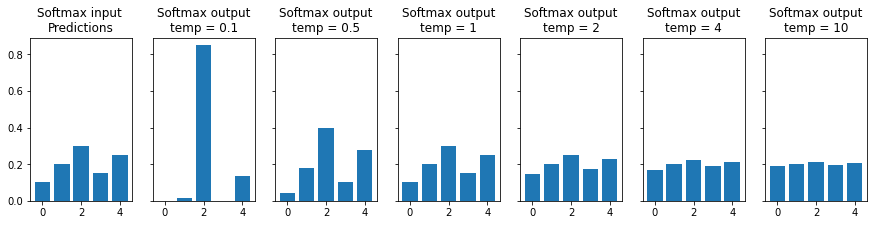

In [12]:
import matplotlib.pyplot as plt

temperatures = [0.1, 0.5, 1, 2, 4, 10]
fig, axs = plt.subplots(1,len(temperatures)+1, figsize=(15,3), sharey=True)

fake_preds=[0.1, 0.2, 0.3, 0.15, 0.25]
x = range(len(fake_preds))

axs[0].bar(x, fake_preds)
axs[0].set_title("Softmax input \nPredictions")
for i, temp in enumerate(temperatures):
    sampled_output, sampled_output = sample(fake_preds,temp)
    axs[i+1].bar(x, sampled_output)
    axs[i+1].set_title(f"Softmax output\ntemp = {temp}")
plt.show()

In [13]:
  # tanítás és 10 epochonként szöveg generálása (összesen 10*10 epoch fut le)
start_index = random.randint(0, len(text) - maxlen - 1)
for iteration in range(1, 10):
    print()
    print('-' * 50)
    print('Iteráció', iteration)
    model.fit(X_dense, y, batch_size=128, epochs=20)
    
    #modelfile="model-it-"+str(iteration)+".h5" # menthetjük a modellt, hogy később tudjuk futtatni
    #model.save(modelfile) # itt elmentjük a modellt, hogy később erre az állapotra vissza tudjunk könni

    for temp in [0.5, 1.0, 1.2]: # a mintavételhez kell majd (temperature)
        print()
        print('----- hőmérséklet:', temp)
        generated = ''
        sentence = text[start_index: start_index + maxlen] # kiválasztunk egy kezdeti szöveget, amiből kiindulunk, a neuronháló ezt fogja folytatni
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        #sys.stdout.write(generated)

        for i in range(150): # legenerálunk 400 karaktert egymás után
            # teszt adat one-hot kódolva LSTM bemenetére
            x = np.zeros((1, maxlen, len(chars)))
            x_dense = np.zeros((1, maxlen, 1))
            for t, char in enumerate(sentence):
            	x[0, t, char_indices[char]] = 1.
            	x_dense[0,t,0]=char_indices[char]

            preds = model.predict(x_dense, verbose=0)[0] # forward pass
            next_index,_ = sample(preds, temp) # kimeneten kapott eloszlásból mintát veszünk
            next_char = indices_char[next_index] # a mintát karakterre képezzük

            generated += next_char
            sentence = sentence[1:] + next_char # léptetünk egy karatert (első kiesik, utolsónak bejön a most generált)

        print(generated) # kiírjuk, amit generáltunk
       
        print()


--------------------------------------------------
Iteráció 1
Epoch 1/20
1340/1340 [==============================] - 17s 6ms/step - loss: 2.9964
Epoch 2/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.4462
Epoch 3/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.3130
Epoch 4/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.2364
Epoch 5/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.1805
Epoch 6/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.1356
Epoch 7/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.0998
Epoch 8/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.0682
Epoch 9/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.0435
Epoch 10/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.0203
Epoch 11/20
1340/1340 [==============================] - 8s 6ms/step - loss: 2.0011
Epoch 12/20
1340/1340